## Imports

In [14]:
from base_Imports_and_Functions import *

Thermals_db = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/netcds/Thermals_data_base.nc')
extent_son = (5.499792, 7.032229, 44.104446, 45.18888)

## Plotting

### ABLH

In [3]:
def major_net_bhl():
    BHL_all = np.zeros((1,1))[0]
    dayofflight = np.zeros((1,1))[0]
    heures = np.zeros((1,1))[0]
    for i in range(6):
        BHL_i = xr.open_dataset('T:/C2H/STAGES/LEO_BARROIS/Netcdfffs/'+str(i+19)+'_BLH.nc')
        BHL_all = np.concatenate((BHL_all,BHL_i['PBLH'].values),axis = 0)
        dayofflight = np.concatenate((dayofflight,np.ones((1,len(BHL_i['PBLH'].values)))[0]*(i+19)),axis = 0)
        heures = np.concatenate((heures,BHL_i['heure'].values),axis = 0)

    return BHL_all[1:],dayofflight[1:],heures[1:]

@njit()
def plot_diurn(extent,BHL,dayofflight,heures):
    hquart = np.zeros((6,24))
    mquart = np.zeros((6,24))
    lquart = np.zeros((6,24))
    
    for i in range(6):
        BHL_day = BHL[dayofflight == i+19]
        heures_day = heures[dayofflight == i+19]
        dayofflight_day = dayofflight[dayofflight == i+19]

        for j in range(24) :
            BHL_day_hour = BHL_day[heures_day == j]
            heures_day_hour = heures_day[heures_day == j]
            dayofflight_day_hour = dayofflight_day[heures_day == j]
            
            if len(BHL_day_hour) != 0 :
                hquart[i,j] = np.nanpercentile(BHL_day_hour,75)
                mquart[i,j] = np.nanpercentile(BHL_day_hour,50)
                lquart[i,j] = np.nanpercentile(BHL_day_hour,25)
            else :
                hquart[i,j] = np.nan
                mquart[i,j] = np.nan
                lquart[i,j] = np.nan

    return hquart,mquart,lquart     

def plotting_all_day_BLH(hquart_,mquart_,lquart_,ax):
    
    styles = ['dashed','solid']
    alphas = [0.5,1,0.5]
    colors = ['#0000FF','#069AF3','#00FFFF','#FFFF00','#F97306','#FF0000']
    
    for i in range(6):
        ax.plot(hquart_[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
        ax.plot(mquart_[i], linestyle = styles[1], alpha = alphas[1], color = colors[i],label = str(i+19) + '/08')
        ax.plot(lquart_[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
    
    ax.set_ylabel('Boundary Layer Height from flights (m asl)')
    
    ticks_time1 = [i for i in range(8,21,2)]
    
    labels_ticks_time = np.array([str(i)+'h' for i in ticks_time1])
    
    ax.grid(visible=True, axis='both', color = '0.80')
    ax.set_xticks(ticks_time1, labels_ticks_time, fontsize=10)
    ax.legend()

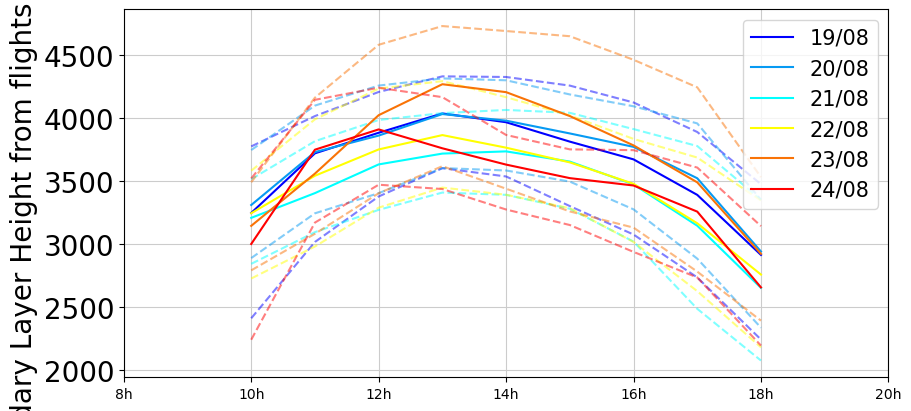

In [6]:
fig, ax = plt.subplots(figsize =(9,4), layout = 'constrained')

BHL_all,dayofflight,heures = major_net_bhl()
hquart,mquart,lquart = plot_diurn(extent_son,BHL_all,dayofflight,heures)
plotting_all_day_BLH(hquart,mquart,lquart,ax)

### Thermals

In [11]:
def new_scatter_th_only_traces(reduced_thermal,extent_son,ngridcell):
 
    dlon = (extent_son[1]-extent_son[0])/ngridcell
    dlat = (extent_son[3]-extent_son[2])/ngridcell

    max_speed_th = np.zeros((4, ngridcell, ngridcell))

    altitudes = np.arange(800,5200,200)
    
    ticks = np.arange(len(altitudes)-1)
    labels_ticks = ['['+str(altitudes[i]) +';'+ str(altitudes[i+1])+ ']' for i in range(len(altitudes)-1)]
    
    dist_speed = []
    alti_th = []
    lon_th = []
    lat_th = []
    simu_m_speed = []
    
    for l in tqdm(range(len(altitudes)-1)) :
        
        reduced_comp_alti = reduced_thermal.where(
            (reduced_thermal['altitude_gnss'] <= altitudes[l+1]) & (reduced_thermal['altitude_gnss'] >= altitudes[l]),
            drop=True) 
    
        indexes = list(set(reduced_comp_alti['index'].values))
        
        for j in indexes :
    
            a_thermal = reduced_comp_alti.where(
                (reduced_comp_alti['index'] == j),
                drop=True) 
            
            if len(a_thermal['altitude_gnss'].values) > 20 :                
    
                a_thermal_alt_sm = smooth(a_thermal['altitude_gnss'].values,window_len=20,window='hanning')
                
                mean_speed = (a_thermal_alt_sm[-1]-a_thermal_alt_sm[0])/(a_thermal['rawtime'].values[-1]-a_thermal['rawtime'].values[0])
                
                foward_alt = a_thermal_alt_sm[2:]
                backward_alt = a_thermal_alt_sm[:-2]
                foward_time = a_thermal['rawtime'].values[2:]
                backward_time = a_thermal['rawtime'].values[:-2]

                max_speed = np.max((foward_alt-backward_alt)/(foward_time-backward_time))
                
                if max_speed > 0 and max_speed < 8 :
                        
                    if a_thermal['type'].values[0] == 0 :
                        max_speed += 1.1
    
                    else :
                        max_speed += 0.6

                    lon = np.mean(a_thermal['longitude'].values)
                    lat = np.mean(a_thermal['latitude'].values)

                    indx, indy = int((lon - extent_son[0])/dlon),int((lat - extent_son[2])/dlat)

                    if 0 < indx < ngridcell and 0 < indy < ngridcell :
                        if max_speed > max_speed_th[0,indx,indy] :
                            max_speed_th[0,indx,indy] = max_speed
                            max_speed_th[2,indx,indy] = (altitudes[l+1]+altitudes[l])/2
                            max_speed_th[3,indx,indy] = a_thermal['type'].values[0]+1
                            max_speed_th[1,indx,indy] = np.nan

    for i in range(ngridcell):
        for j in range(ngridcell):
            if max_speed_th[2,i,j] < 100 :
                 max_speed_th[0,i,j],max_speed_th[1,i,j],max_speed_th[2,i,j],max_speed_th[3,i,j] = np.nan, np.nan, np.nan, np.nan

    return max_speed_th
    
@njit()
def selecton_type_th(max_speed_th):
    a,b,c = np.shape(max_speed_th)
    ind_para = np.zeros((b,c))
    ind_plan = np.zeros((b,c))
    for i in range(b):
        for j in range(c):
            if max_speed_th[3,i,j] == 1 :
                ind_para[i,j] = 1
                ind_plan[i,j] = np.nan
            elif max_speed_th[3,i,j] == 2 :
                ind_plan[i,j] = 1
                ind_para[i,j] = np.nan
            else :
                ind_para[i,j] = np.nan
                ind_plan[i,j] = np.nan

    return ind_para, ind_plan

@njit()
def remove_plan_para(max_speed_th):
    ind_para, ind_plan = selecton_type_th(max_speed_th)
    a,b,c = np.shape(max_speed_th)
    res_para = np.zeros((3,b,c))
    res_plan = np.zeros((3,b,c))
    for i in range(b):
        for j in range(c):
            if np.isnan(ind_para[i,j]) == False :
                res_para[:,i,j] = max_speed_th[:-1,i,j]
#                res_plan[:,i,j] = np.nan
            elif np.isnan(ind_plan[i,j]) == False:
                res_plan[:,i,j] = max_speed_th[:-1,i,j]
#                res_para[:,i,j] = np.nan

    return res_para, res_plan

def major_net_th(thermals_reduced,ngridcell,extent_son):
    th_all_h = np.zeros((6,24))
    th_all_m = np.zeros((6,24))
    th_all_l = np.zeros((6,24))
    for i in range(6):
        th_i = thermals_reduced.where(
            (thermals_reduced['dayofflight'] == i+19),
            drop = True)
        
        for j in range(24):

            th_j = th_i.where(
                (thermals_reduced['rawtime'] >= j*60*60) & (thermals_reduced['rawtime'] <= (j+1)*60*60),
                drop = True)

            if len(th_j['type']) != 0 :
                max_speed_th_j = new_scatter_th_only_traces(th_j,extent_son,ngridcell)
                th_all_h[i,j] = np.nanpercentile(max_speed_th_j[0],75)
                th_all_m[i,j] = np.nanpercentile(max_speed_th_j[0],50)
                th_all_l[i,j] = np.nanpercentile(max_speed_th_j[0],25)

            else :
                th_all_h[i,j] = np.nan
                th_all_m[i,j] = np.nan
                th_all_l[i,j] = np.nan   

    return th_all_h,th_all_m,th_all_l

def plotting_all_day_BLH_th(hquart_bhl,mquart_bhl,lquart_bhl,hquart_th,mquart_th,lquart_th):   
    styles = ['dashed','solid']
    alphas = [0.5,1,0.5]
    colors = ['#0000FF','#069AF3','#00FFFF','#FFFF00','#F97306','#FF0000']
    ax = axs[0]
    for i in range(6):
        ax.plot(hquart_bhl[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
        ax.plot(mquart_bhl[i], linestyle = styles[1], alpha = alphas[1], color = colors[i],label = str(i+19) + '/08')
        ax.plot(lquart_bhl[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
    
    ax.set_ylabel('BLH from flights (m asl)',fontsize = 15)
    
    ticks_time1 = [i for i in range(6,21,2)]
    
    labels_ticks_time = np.array([str(i)+'h' for i in ticks_time1])
    
    ax.grid(visible=True, axis='both', color = '0.80')
    ax.set_xticks(ticks_time1, labels_ticks_time, fontsize=15)
    ax.legend(fontsize = 13)
    ax.text(-0.1, 1.1, string.ascii_lowercase[0], transform=ax.transAxes, 
        size=20, weight='bold')

    ax = axs[1]

    for i in range(6):
        ax.plot(hquart_th[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
        ax.plot(mquart_th[i], linestyle = styles[1], alpha = alphas[1], color = colors[i],label = str(i+19) + '/08')
        ax.plot(lquart_th[i], linestyle = styles[0], alpha = alphas[0], color = colors[i])
    
    ax.set_ylabel('W max thermals ($m.s^{-1}$)',fontsize = 15)
    
    ticks_time1 = [i for i in range(6,21,2)]
    
    labels_ticks_time = np.array([str(i)+'h' for i in ticks_time1])
    
    ax.grid(visible=True, axis='both', color = '0.80')
    ax.set_xticks(ticks_time1, labels_ticks_time, fontsize=15)
    ax.legend(fontsize = 13)

    ax.text(-0.1, 1.1, string.ascii_lowercase[1], transform=ax.transAxes, 
        size=20, weight='bold')

In [15]:
thermals_reduced = Thermals_db.where( 
    (Thermals_db['longitude'] >= extent_son[0]) & (Thermals_db['longitude'] <= extent_son[1]) & 
    (Thermals_db['latitude'] >= extent_son[2]) & (Thermals_db['latitude'] <= extent_son[3]),
    drop = True)

ngridcell = 100
th_all_h,th_all_m,th_all_l = major_net_th(thermals_reduced,ngridcell,extent_son)

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 404.64it/s]
C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 547.97it/s]
C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 555.47it/s]
C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 181.21it/s]


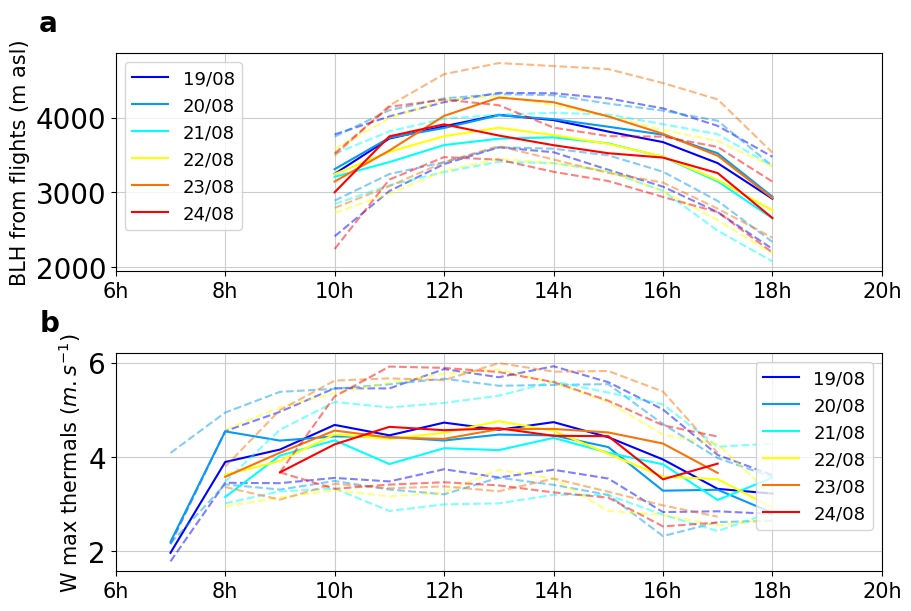

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols = 1,figsize =(9,6), layout = 'constrained')

plotting_all_day_BLH_th(hquart,mquart,lquart,th_all_h,th_all_m,th_all_l)

plt.savefig(savefig_path+'BLH_th_all_days.png')